# MET CS 767 - Machine Learning  - Final Project
# Prasad Kothpalli
# Stock Price Prediction Problem Using ARIMA Method

## Loading and Handling Data into pandas using Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
print(pd.__version__)

1.0.3


In [ ]:
# Import Yahoo Finance Library to get the historical data for any Given US and International Stocks
# Tried with Several Stock Symbols from NASDAQ and preseting NFLX symbol for comapsirion with other ML Techniques

In [57]:
from pandas_datareader import data as pdr #extract data from internet sources into pandas data frame
import yfinance as yf

yf.pdr_override()
start_date = "2018-02-13"
end_date = "2020-03-20"
stocks = 'NFLX'
data = pdr.get_data_yahoo(stocks, start = start_date, end = end_date )
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400
2018-02-20,277.739990,285.809998,276.609985,278.549988,278.549988,7769000
...,...,...,...,...,...,...
2020-03-13,330.510010,336.420013,307.390015,336.299988,336.299988,9458200
2020-03-16,306.630005,334.350006,294.750000,298.839996,298.839996,10559900
2020-03-17,306.190002,322.899994,290.250000,319.750000,319.750000,10013900


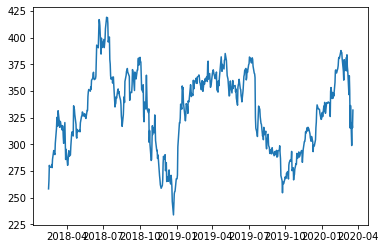

In [58]:
## Prepare timeseries data based on Date as Index
data.index
# Daily Closing price as a time series data
data_close = data['Close']
# plot the daily closing price data
plt.plot(data_close)

In [ ]:
# Compute Technical Indicators 

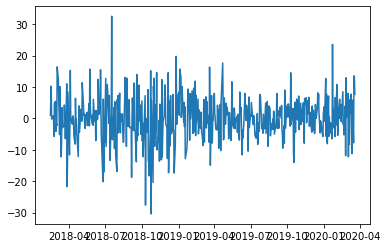

In [60]:
# Compute daily return, price change in a day from start to end of trading day
data['Return'] =  data['Close'] - data['Open']
# plot Daily return 
plt.plot(data.Return)

# Processing financial data for Deep Learning
#1. Economically meaningful quantities of interest out of the raw inputs
#2. Compute an exponentially weighted moving average and variance of the quantities of interest 
#3. Package our results in a format appropriate for the recurrent deep learning model we will use to fit the data. 


In [61]:
# 1st Quantiles of interest
# Daily volatility is a Quantity of Interest
# Daily Volatility is another interest - Daily Volatility = difference between highest 
# and lowest prices recorded during trading day
data['DailyVolatility'] = data['High'] - data['Low']

data.index.name='Date'
data['DailyVolatility']

Date
2018-02-13     6.710007
2018-02-14     9.550018
2018-02-15    12.869995
2018-02-16     6.269989
2018-02-20     9.200012
                ...    
2020-03-13    29.029999
2020-03-16    39.600006
2020-03-17    32.649994
2020-03-18    31.579987
2020-03-19    31.690002
Name: DailyVolatility, Length: 528, dtype: float64

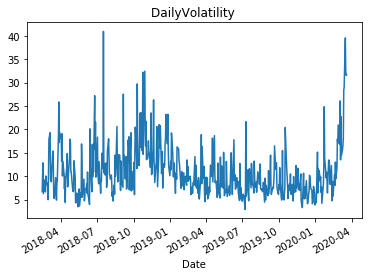

In [62]:
# Plot Daily Volatility

data.DailyVolatility.plot(x='Date', y='DailyVolatility',title='DailyVolatility ')

In [63]:
# Scaling Quantities of Interest Without a Lookahead
# 2nd quantiles of Interest are 
#1. Previous daily returns
#2. Previous daily volatility
#3. Previous daily volume

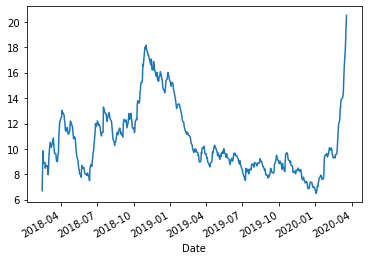

In [64]:
# compute the exponentially weighted moving average (ewdf) of every column in the data frame, 
# and plot the daily volatility’s exponentially weighted moving average
ewdf = data.ewm(halflife = 10).mean()
ewdf.DailyVolatility.plot()

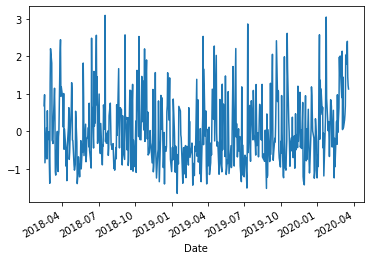

In [65]:
# compute exponentially weighted moving variance 
vewdf = data.ewm(halflife = 10).var()

# scale by demeaning and normalizing
scaled = data.DailyVolatility - ewdf.DailyVolatility
scaled = scaled / vewdf.DailyVolatility**0.5
scaled.plot()

In [66]:
#transform all three raw inputs of interest into a scaled version as follows:
# Compute Scaled Volatality, Return and Volume as shown below
data['ScaledVolatility'] = ((data.DailyVolatility - 
                           ewdf.DailyVolatility) 
                           / vewdf.DailyVolatility**0.5 )
data['ScaledReturn']     = ((data.Return - ewdf.Return) 
                            / vewdf.Return**0.5 )
data['ScaledVolume']     = ((data.Volume - ewdf.Volume)
                          / vewdf.Volume**0.5 )

In [67]:
# Drop NA results from exponential smoothing
data = data.dropna()

In [68]:
#convert Adj Close data to time series:
ts = data['Adj Close']
ts.head(10)

Date
2018-02-14    266.000000
2018-02-15    280.269989
2018-02-16    278.519989
2018-02-20    278.549988
2018-02-21    281.040009
2018-02-22    278.140015
2018-02-23    285.929993
2018-02-26    294.160004
2018-02-27    290.609985
2018-02-28    291.380005
Name: Adj Close, dtype: float64

### Indexing TS arrays:

In [71]:
#1. Specific the index as a string constant:
ts['2019-01-18']

339.1000061035156

In [72]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(2019, 3, 26)]

359.9700012207031

# Checking for stationarity

## Plot the time-series

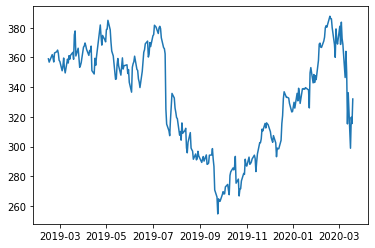

In [22]:
plt.plot(ts)

### Function for testing stationarity

In [82]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=20).mean()
    # print(rolmean)
    
    rolstd = pd.Series(timeseries).rolling(window=20).std()
    # print(rolstd)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['open','high','10_day_volatility', '50_day_moving_avg'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

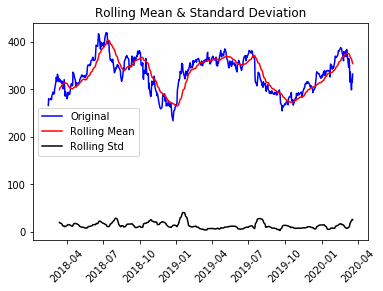

Results of Dickey-Fuller Test:
open                     -2.456724
high                      0.126362
10_day_volatility         8.000000
50_day_moving_avg       518.000000
Critical Value (1%)      -3.443037
Critical Value (5%)      -2.867136
Critical Value (10%)     -2.569750
dtype: float64


In [83]:
#ts
test_stationarity(ts)


# Making Data Stationary
# Estimating & Eliminating Trend

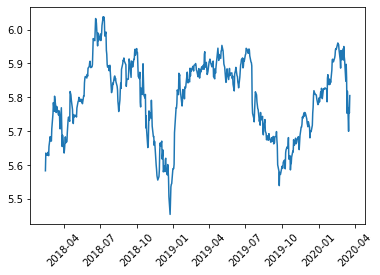

In [84]:
ts_log = np.log(ts)
plt.xticks(rotation=45)
plt.plot(ts_log)

## Smoothing:
### Moving average

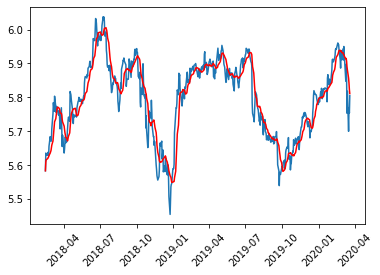

In [86]:
#moving_avg = pd.rolling_mean(ts_log, 10, min_periods=1)
moving_avg = pd.Series(ts_log).rolling(10, min_periods=1).mean()
plt.plot(ts_log)
plt.xticks(rotation=45)
plt.plot(moving_avg, color='red')

In [28]:
ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.head(15)

In [29]:
ts_log_moving_avg_diff.dropna(inplace=True)
#ts_log_moving_avg_diff.head()

In [30]:
#test_stationarity(ts_log_moving_avg_diff)

### Exponentially Weighted Moving Average

            Adj Close
Date                 
2018-02-14   5.583496
2018-02-15   5.610379
2018-02-16   5.617121
2018-02-20   5.620515
2018-02-21   5.624539
...               ...
2020-03-13   5.879457
2020-03-16   5.869380
2020-03-17   5.863664
2020-03-18   5.857512
2020-03-19   5.854578

[527 rows x 1 columns]


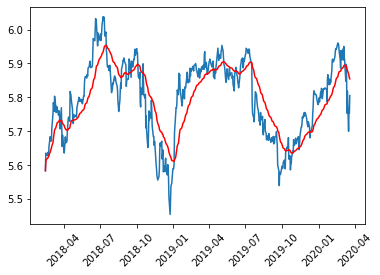

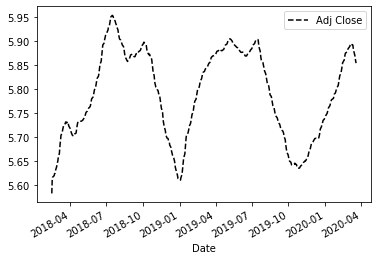

In [88]:
#expwighted_avg = pd.ewma(ts_log, halflife=12)
expwighted_avg = pd.DataFrame(ts_log).ewm(halflife=12).mean()
print(expwighted_avg)
plt.xticks(rotation=45)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
expwighted_avg.plot(style='k--')

In [89]:
ts_log_ewma_diff = ts_log - expwighted_avg
#print(ts_log_ewma_diff)
#test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

### Differencing:

#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

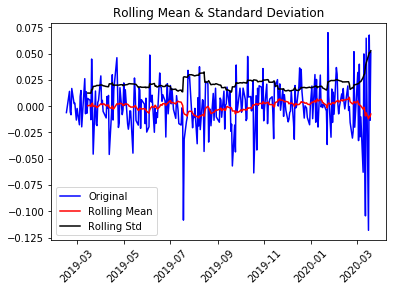

Results of Dickey-Fuller Test:
open                     -5.479225
high                      0.000002
10_day_volatility         8.000000
50_day_moving_avg       266.000000
Critical Value (1%)      -3.455175
Critical Value (5%)      -2.872468
Critical Value (10%)     -2.572593
dtype: float64


In [90]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition 

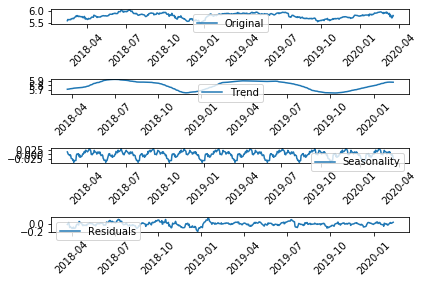

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()

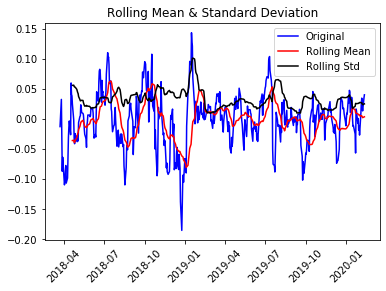

Results of Dickey-Fuller Test:
open                   -5.870165e+00
high                    3.254365e-07
10_day_volatility       0.000000e+00
50_day_moving_avg       4.740000e+02
Critical Value (1%)    -3.444221e+00
Critical Value (5%)    -2.867657e+00
Critical Value (10%)   -2.570028e+00
dtype: float64


In [94]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Final Forecasting

In [95]:
from statsmodels.tsa.arima_model import ARIMA

### ACF & PACF Plots

C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


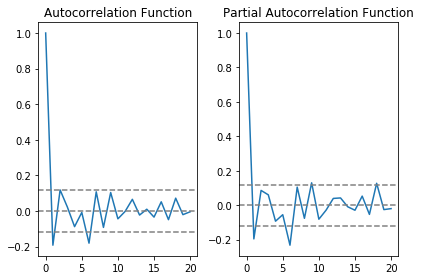

In [96]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### AR Model:

C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

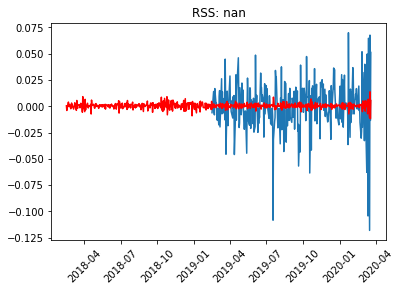

In [98]:
#MA model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.xticks(rotation=45)
plt.plot(results_AR.fittedvalues, color='red')
plt.xticks(rotation=45)
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model

C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\prasadvk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

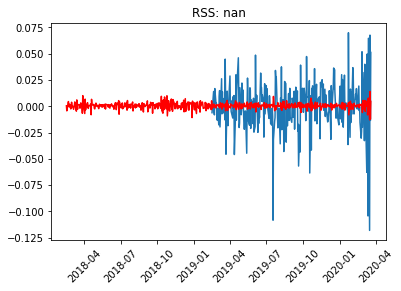

In [99]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.xticks(rotation=45)
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [41]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  275
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 642.047
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 28 Apr 2020   AIC                          -1276.093
Time:                        16:43:09   BIC                          -1261.626
Sample:                             1   HQIC                         -1270.287
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.001     -0.202      0.840      -0.003       0.002
ma.L1.D.Adj Close    -0.1841      0.060     -3.085      0.002      -0.301      -0.067
ma.L2.D.Adj Close     0.

### Convert to original scale:

In [43]:
#results_MA.fittedvalues

In [100]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=False)
#print (predictions_ARIMA_diff.head())

In [101]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print (predictions_ARIMA_diff_cumsum.head())

In [104]:
# ts_log
pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_diff_cumsum

Date
2018-02-15    0.000418
2018-02-16   -0.003976
2018-02-20    0.000468
2018-02-21    0.001125
2018-02-22    0.000495
                ...   
2020-03-13    0.226898
2020-03-16    0.213963
2020-03-17    0.227876
2020-03-18    0.215654
2020-03-19    0.220239
Length: 526, dtype: float64

In [107]:
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head(-9)
predictions_ARIMA_log

Date
2018-02-14    5.583496
2018-02-15    5.636172
2018-02-16    5.625514
2018-02-20    5.630065
2018-02-21    5.639622
                ...   
2020-03-13    6.044901
2020-03-16    5.913872
2020-03-17    5.995415
2020-03-18    5.969718
2020-03-19    6.025464
Length: 527, dtype: float64

In [108]:
#ts_log.head(-9)

In [109]:
# ts_log

In [115]:
predictions_ARIMA_log

Date
2018-02-14    5.583496
2018-02-15    5.636172
2018-02-16    5.625514
2018-02-20    5.630065
2018-02-21    5.639622
                ...   
2020-03-13    6.044901
2020-03-16    5.913872
2020-03-17    5.995415
2020-03-18    5.969718
2020-03-19    6.025464
Length: 527, dtype: float64

(array([736785., 736876., 736968., 737060., 737150., 737241., 737333.,
        737425., 737516.]), <a list of 9 Text xticklabel objects>)

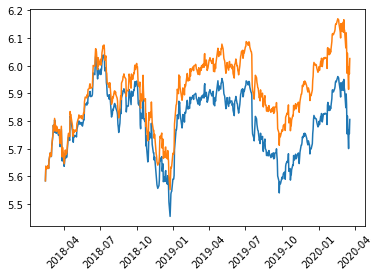

In [116]:
plt.plot(ts_log)
plt.xticks(rotation=45)
plt.plot(predictions_ARIMA_log)
plt.xticks(rotation=45)

Text(0.5, 1.0, 'RMSE: 45.3067')

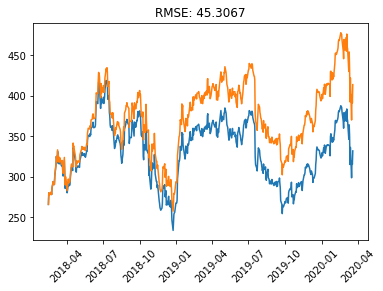

In [117]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.xticks(rotation=45)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))